# Machine Learning Classification Methods
This notebook will use a variety of other more basic classification methods using machine learning. We will then be able to evaluate these against the neural network earlier constructed. We can then evaluate the probability distributions for test precitions, the AUC-ROC cruves and the Punzi FOM value as a function of probability cut. 

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from dataflow import Flow

In [2]:
data = Flow(None, None, None, '../neural_network/csv/preselected_feat_v5.0.5_equalRatio_restrictedSideband.csv')
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data.get_train_val_test_split()

In [3]:
def get_metrics(model, use_test=False):
    """
    Get a lot of useful metrics from the fit model which will now
    be tested on the validation data can convert to test if needed
    
    Parameters
    ----------
    model : object
        A particular instance of some model which takes the usual
        predict and predict_proba and fit methods
    """
    
    X = X_val   
    Y = y_val 
    if use_test:
        X = X_test
        Y = y_test
    Y = Y.to_numpy()
        
    predicted_probabilities = model.predict_proba(X)
    # Generate model predictions on these input data e.g. event 1 [prob sig, prob bg]
    
    pred_signal_probs = predicted_probabilities[:,0]
    pred_bg_probs = predicted_probabilities[:,1]
    
    bins = np.linspace(0, 1, 11)
    # Generate 11 bin edges i.e. 10 bins
    probability_distribution_s, _ = np.histogram(pred_signal_probs, bins=bins, density=True)
    probability_distribution_b, _ = np.histogram(pred_bg_probs, bins=bins, density=True)
    prob_dist_with_bins = [[probability_distribution_s, bins], [probability_distribution_b, bins]]
    # Get the frequencies and bin edges and dump them into a list

    predicted_classes = model.predict(X)
    # Sort via a 0.5 cut point these predictions into predicted classes
    n_correct = np.count_nonzero((predicted_classes == Y))
    binary_accuracy = n_correct / len(predicted_classes)
    
    return prob_dist_with_bins, binary_accuracy


def plot_prob_dist(probs, bins):
    probs = list(probs)
    labels = ['Train', 'Validation', 'Test']
    colours = ['b', 'r', 'g']
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fonts = {'fontname':'Arial'}
    
    ax.hist(y_test, bins=bins, histtype='step', )
    for i, p in enumerate(probs):
        ax.hist(p, bins=bins, histtype='step', label=labels[i], density=True, color=colours[i], linewidth=2)
    
    plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
    plt.xlabel('Probability', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
    plt.legend(loc='upper right', bbox_to_anchor=(0.7, 0.95), ncol=1, fancybox=False, shadow=True, frameon=False)
    plt.show()
    

## KNN Classifier

In [4]:
knn_classifier = KNeighborsClassifier(n_neighbors=40)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [5]:
probs, bin_acc = get_metrics(knn_classifier)
print(f'Validation Binary Accuracy: {bin_acc:.5f}')

Validation Binary Accuracy: 0.91359


## XGBoost + RandomForestClassifier

In [6]:
params = {"objective": "binary:logistic",
          "eta": 0.3,
          "max_depth": 5,
          "min_child_weight": 3,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "learning_rate": 0.2,
          "seed": 1}

rf = RandomForestClassifier(n_estimators=120, random_state=1)
rf.fit(X_train, y_train)

num_trees=250
gbm = xgb.train(params, xgb.DMatrix(X_train, y_train), num_trees)

test_probs = (rf.predict_proba(X_val)[:,1] + gbm.predict(xgb.DMatrix(X_val)))/2

[13:52:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
# Evaluate the predictions now...
classes = np.where(test_probs > 0.5, 1, 0)
value_counts = np.count_nonzero(classes == y_val)
print(f'Binary Accuracy: {value_counts/len(classes):.5f}')

Binary Accuracy: 0.93955


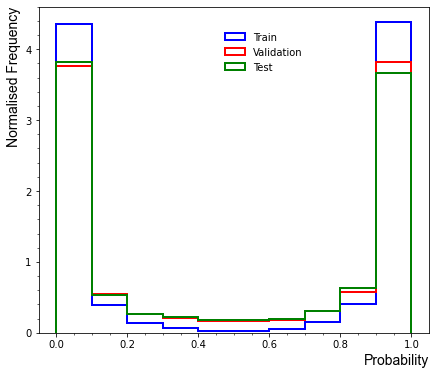

In [8]:
bins = np.linspace(0, 1, 11)

train_probs = (rf.predict_proba(X_train)[:,1] + gbm.predict(xgb.DMatrix(X_train)))/2
test_probs = (rf.predict_proba(X_test)[:,1] + gbm.predict(xgb.DMatrix(X_test)))/2
val_probs = (rf.predict_proba(X_val)[:,1] + gbm.predict(xgb.DMatrix(X_val)))/2

plot_prob_dist([train_probs, val_probs, test_probs], bins)